In [1]:
import numpy as np

import torch
from torch import nn

%matplotlib inline
from matplotlib import pyplot as plt

import cv2
import numpy as np
from pathlib import Path
from PIL import Image

import time
import json
import re

In [2]:
current_folder = Path.cwd()
tesi_folder = Path('~/Scuola/now').expanduser()

In [ ]:
with open(tesi_folder / 'experiments.json', 'r') as reader:
    experiments = json.load(reader)

In [47]:
def plot_metric(axis, metrics, label, xrange=None, ylim=[0, 200], color='black', legend_loc=None):
    if xrange is None:
        done = len(metrics)
        xrange = list(range(1, done + 1))
        
    axis.plot(
        xrange, metrics, label=label, color=color
    )

    if ylim:
        axis.set_ylim(ylim)
    
    if legend_loc:
        axis.legend(loc=legend_loc)


def plot_metrics(axis, train_metrics, eval_metrics, xrange=None, train_ylim=[0, 30], eval_ylim=[0, 100]):
    plot_metric(
        axis,
        train_metrics,
        'on TRAIN set (S1, S6, S7, S8)',
        xrange=xrange,
        ylim=train_ylim,
        color='red',
        legend_loc='upper left'
    )
    
    axis = axis.twinx()
        
    plot_metric(
        axis,
        eval_metrics,
        'on EVAL set (S9, S11)',
        xrange=xrange,
        ylim=eval_ylim,
        color='green',
        legend_loc='upper right'
    )

In [35]:
def get_figsize(n_rows, n_cols, row_size=8, column_size=24):
    return (n_cols * column_size, n_rows * row_size)


def get_figa(n_rows, n_cols, heigth=8, width=24):
    fig_size = get_figsize(n_rows, n_cols, row_size=heigth, column_size=width)
    fig, ax = plt.subplots(n_rows, n_cols, figsize=fig_size)
    return fig, ax

In [ ]:
fig, ax = get_figa(2, 1)

for axis, metrics in zip(
        ax.ravel(),
        [experiments['04_08_13_09'], experiments['04_09_12_32']]
    ):

    train_metrics = metrics['train'] if 'train' in metrics else []
    eval_metrics = metrics['eval'] if 'eval' in metrics else []

    plot_metrics(
        axis,
        np.float32(train_metrics) / 4.0,  # 4 subjects
        np.float32(eval_metrics) / 2.0,  # 2 subjects
        train_ylim=[0, 200], eval_ylim=[300, 600]
    )

    axis.set_xlim([1, 300])

    axis.grid(True)
    axis.set_ylabel('3D MPJPE')
    axis.set_xlabel('epoch')
    
    axis.set_title(metrics['title'])

In [5]:
def get_lines(f_path):
    lines = []

    with open(f_path, 'r') as reader:
        lines = reader.readlines()
        lines = [
            line.strip()
            for line in lines
        ]
        
    return lines


def parse_metrics_log(f_path):
    lines = get_lines(f_path)
    split_index = lines.index('... on EVALuation set')
    training_stop_index = split_index - 1
    eval_start_index = split_index + 1
    
    is_fp_number = lambda x: not (re.match('\d.', x) is None)
    parse_fp_number = lambda x: float(x)
    
    train_metrics = map(
        parse_fp_number,
        filter(is_fp_number, lines[:training_stop_index])
    )
    
    eval_metrics = map(
        parse_fp_number,
        filter(is_fp_number, lines[eval_start_index:])
    )
    
    return list(train_metrics), list(eval_metrics)


def parse_job_log(f_path):
    lines = get_lines(f_path)
    pass  # todo

Text(0.5, 0, 'seconds')

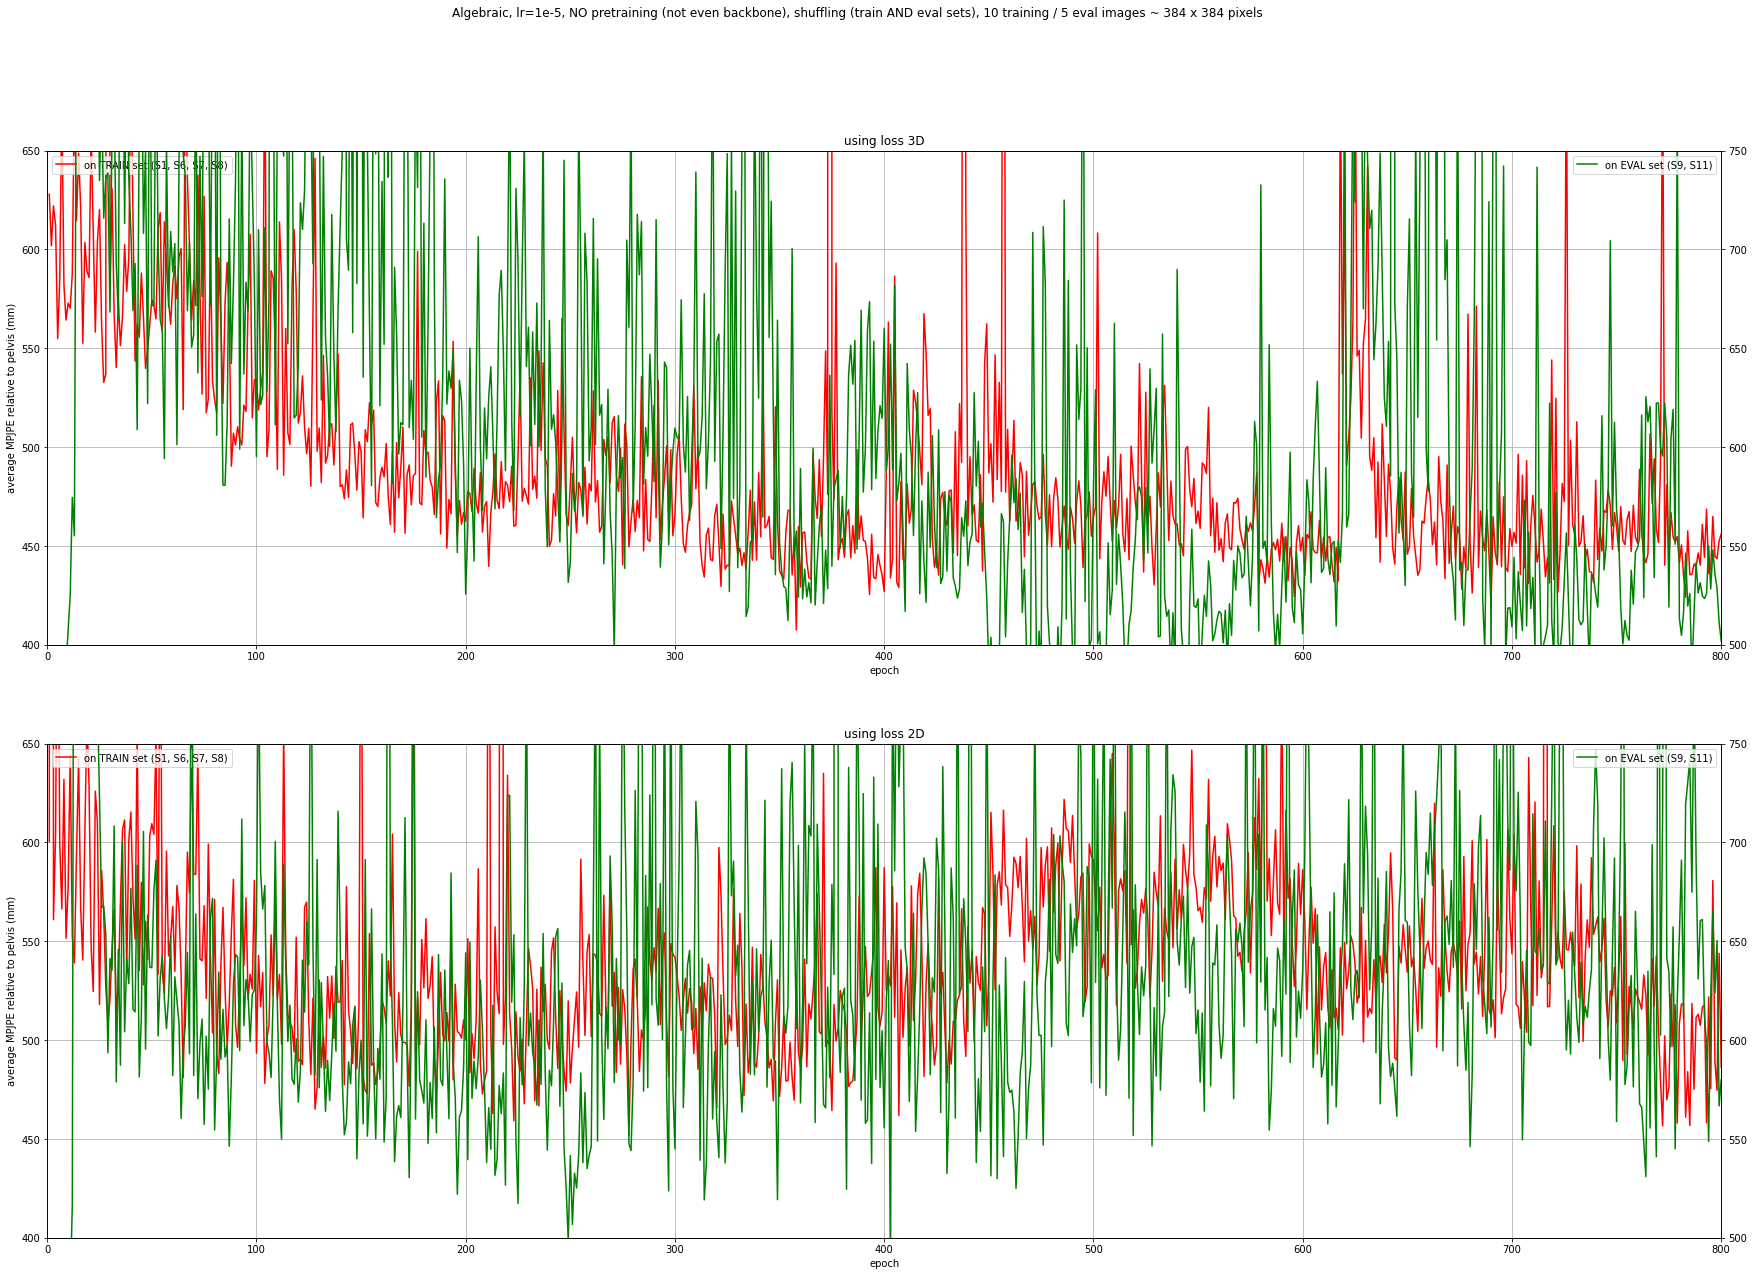

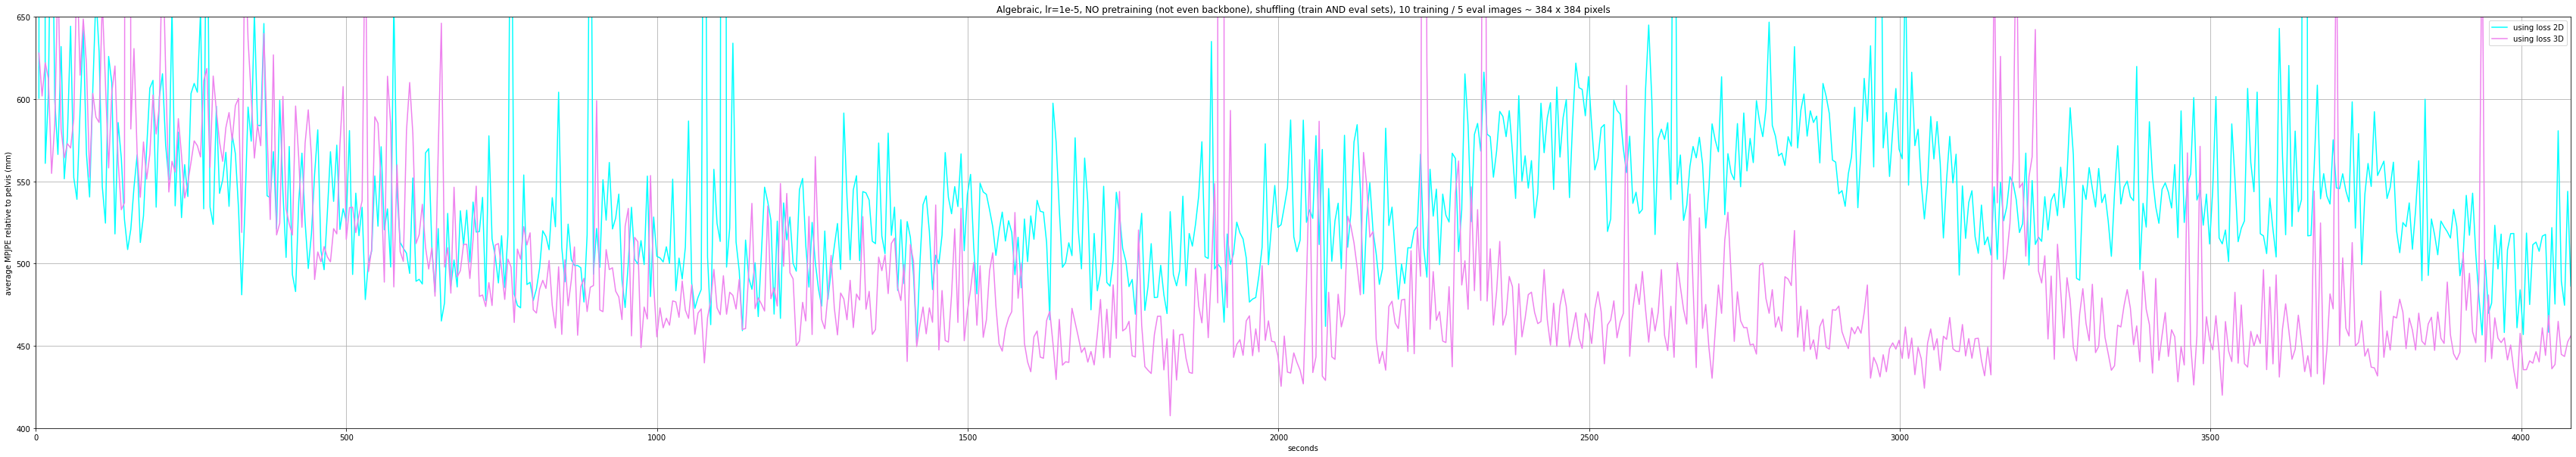

In [119]:
fig, axis = get_figa(2, 1, heigth=10, width=30)

train_ylim = [400, 650]
eval_ylim = [500, 750]

train_metrics, eval_metrics = parse_metrics_log(tesi_folder / 'metrics_logs' / 'no_pre_3d.txt')
ax = axis.ravel()[0]
plot_metrics(ax, train_metrics, eval_metrics, train_ylim=train_ylim, eval_ylim=eval_ylim)

ax.set_ylim(train_ylim)
ax.set_xlim([0, 800])
ax.grid(True)
ax.set_title('using loss 3D')
ax.set_ylabel('average MPJPE relative to pelvis (mm)')
ax.set_xlabel('epoch')

train_metrics, eval_metrics = parse_metrics_log(tesi_folder / 'metrics_logs' / 'no_pre_2d.txt')
ax = axis.ravel()[1]
plot_metrics(ax, train_metrics, eval_metrics, train_ylim=train_ylim, eval_ylim=eval_ylim)

ax.set_ylim(train_ylim)
ax.set_xlim([0, 800])
ax.grid(True)
ax.set_title('using loss 2D')
ax.set_ylabel('average MPJPE relative to pelvis (mm)')
ax.set_xlabel('epoch')

fig.suptitle('Algebraic, lr=1e-5, NO pretraining (not even backbone), shuffling (train AND eval sets), 10 training / 5 eval images ~ 384 x 384 pixels')

# BB_from_scratch.png

fig, ax = get_figa(1, 1, heigth=10, width=60)

train_metrics, _ = parse_metrics_log(tesi_folder / 'metrics_logs' / 'no_pre_2d.txt')
avg_sec_per_epoch = 3.8 + 1.3  # from `tail -n30 13372314.out`
total_epochs = len(train_metrics)
xrange = avg_sec_per_epoch * np.arange(1, total_epochs + 1)

plot_metric(
    ax,
    train_metrics,
    'using loss 2D',
    xrange=xrange,
    ylim=train_ylim,
    color='cyan',
    legend_loc='upper right'
)

train_metrics, _ = parse_metrics_log(tesi_folder / 'metrics_logs' / 'no_pre_3d.txt')
avg_sec_per_epoch = 3.9 + 1.2  # from `tail -n30 13372538.out`
total_epochs = len(train_metrics)
xrange = avg_sec_per_epoch * np.arange(1, total_epochs + 1)

plot_metric(
    ax,
    train_metrics,
    'using loss 3D',
    xrange=xrange,
    ylim=train_ylim,
    color='violet',
    legend_loc='upper right'
)

ax.set_ylim(train_ylim)
ax.set_xlim([0, xrange[-1]])
ax.grid(True)

ax.set_title('Algebraic, lr=1e-5, NO pretraining (not even backbone), shuffling (train AND eval sets), 10 training / 5 eval images ~ 384 x 384 pixels')
ax.set_ylabel('average MPJPE relative to pelvis (mm)')
ax.set_xlabel('seconds')

# bench_no_pretrain_3D_VS_2D.png

Text(0.5, 0.98, 'Algebraic, lr=1e-5, pretraining JUST backbone, shuffling (train AND eval sets), 10 training / 5 eval images ~ 384 x 384 pixels')

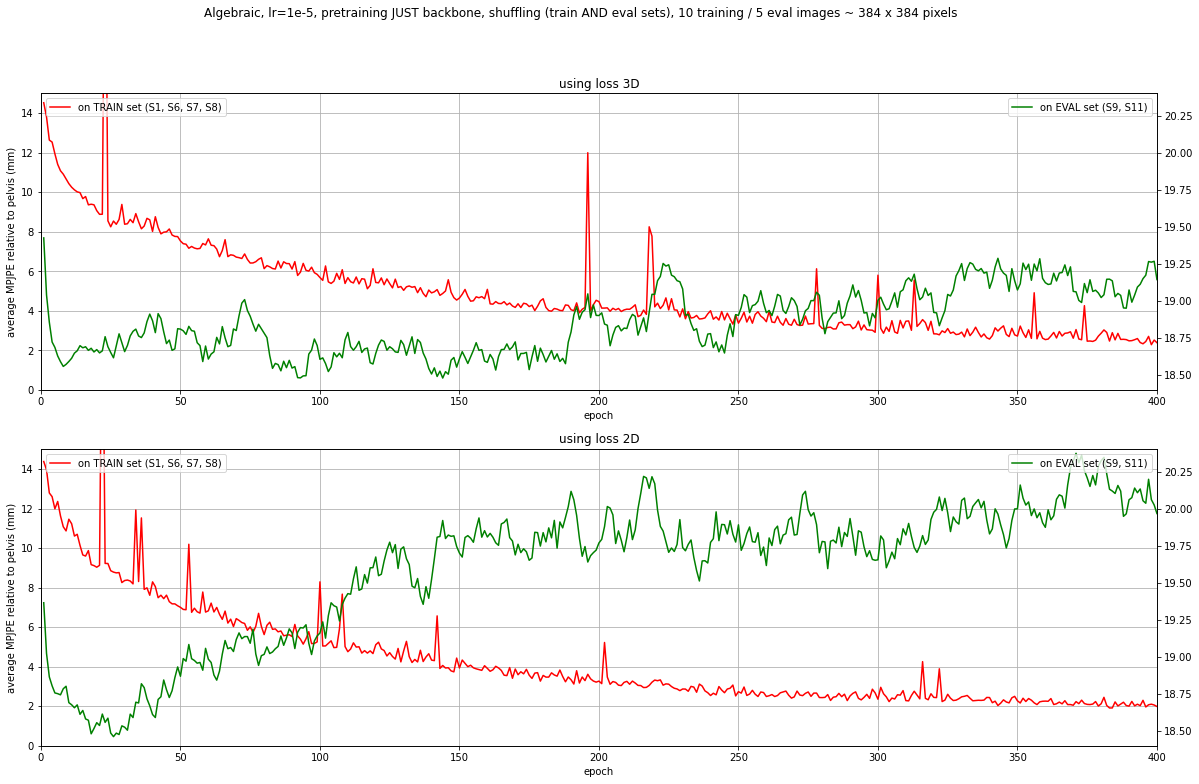

In [98]:
fig, axis = get_figa(2, 1, heigth=6, width=20)

train_ylim = [0, 15]
eval_ylim = [18.4, 20.4]

train_metrics, eval_metrics = parse_metrics_log(tesi_folder / 'metrics_logs' / 'just_BB_3d.txt')
ax = axis.ravel()[0]
plot_metrics(ax, train_metrics, eval_metrics, train_ylim=train_ylim, eval_ylim=eval_ylim)

ax.set_ylim(train_ylim)
ax.set_xlim([0, 400])
ax.grid(True)
ax.set_title('using loss 3D')
ax.set_ylabel('average MPJPE relative to pelvis (mm)')
ax.set_xlabel('epoch')

train_metrics, eval_metrics = parse_metrics_log(tesi_folder / 'metrics_logs' / 'just_BB_2d.txt')
ax = axis.ravel()[1]
plot_metrics(ax, train_metrics, eval_metrics, train_ylim=train_ylim, eval_ylim=eval_ylim)

ax.set_ylim(train_ylim)
ax.set_xlim([0, 400])
ax.grid(True)
ax.set_title('using loss 2D')
ax.set_ylabel('average MPJPE relative to pelvis (mm)')
ax.set_xlabel('epoch')

fig.suptitle('Algebraic, lr=1e-5, pretraining JUST backbone, shuffling (train AND eval sets), 10 training / 5 eval images ~ 384 x 384 pixels')

# BB_pretrained.png

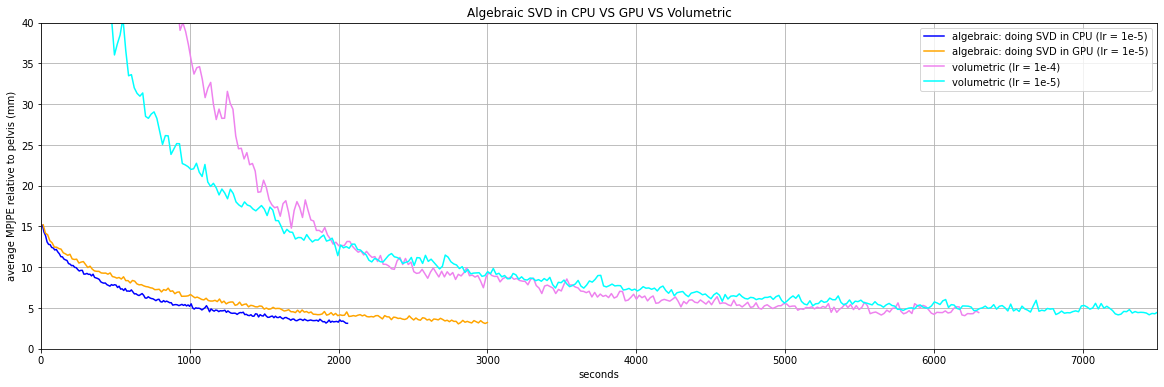

In [86]:
fig, ax = get_figa(1, 1, heigth=6, width=20)

train_metrics, _ = parse_metrics_log(tesi_folder / 'metrics_logs' / 'svd_cpu.txt')
avg_sec_per_epoch = 9.1 + 1.2  # from `tail -n30 13349845.out`
total_epochs = len(train_metrics)
xrange = avg_sec_per_epoch * np.arange(1, total_epochs + 1)

plot_metric(
    ax,
    train_metrics,
    'algebraic: doing SVD in CPU (lr = 1e-5)',
    xrange=xrange,
    ylim=[3, 17],
    color='blue',
    legend_loc='upper left'
)

train_metrics, _ = parse_metrics_log(tesi_folder / 'metrics_logs' / 'svd_gpu.txt')
avg_sec_per_epoch = 13.3 + 1.7
total_epochs = len(train_metrics)
xrange = avg_sec_per_epoch * np.arange(1, total_epochs + 1)

plot_metric(
    ax,
    train_metrics,
    'algebraic: doing SVD in GPU (lr = 1e-5)',
    xrange=xrange,
    ylim=[3, 17],
    color='orange',
    legend_loc='upper left'
)

train_metrics, _ = parse_metrics_log(tesi_folder / 'metrics_logs' / 'vol_continued.txt')
avg_sec_per_epoch = 17.0 + 1.7
total_epochs = len(train_metrics)
xrange = avg_sec_per_epoch * np.arange(1, total_epochs + 1)

plot_metric(
    ax,
    train_metrics,
    'volumetric (lr = 1e-4)',
    xrange=xrange,
    ylim=[3, 30],
    color='violet',
    legend_loc='upper right'
)

train_metrics, _ = parse_metrics_log(tesi_folder / 'metrics_logs' / 'vol_lr1e5.txt')
avg_sec_per_epoch = 17.2 + 1.8
total_epochs = len(train_metrics)
xrange = avg_sec_per_epoch * np.arange(1, total_epochs + 1)

plot_metric(
    ax,
    train_metrics,
    'volumetric (lr = 1e-5)',
    xrange=xrange,
    ylim=[3, 30],
    color='cyan',
    legend_loc='upper right'
)

ax.set_ylim([0, 40])
ax.set_xlim([0, 7500])
ax.grid(True)

ax.set_title('Algebraic SVD in CPU VS GPU VS Volumetric')
ax.set_ylabel('average MPJPE relative to pelvis (mm)')
ax.set_xlabel('seconds')

Text(0.5, 0, 'seconds')

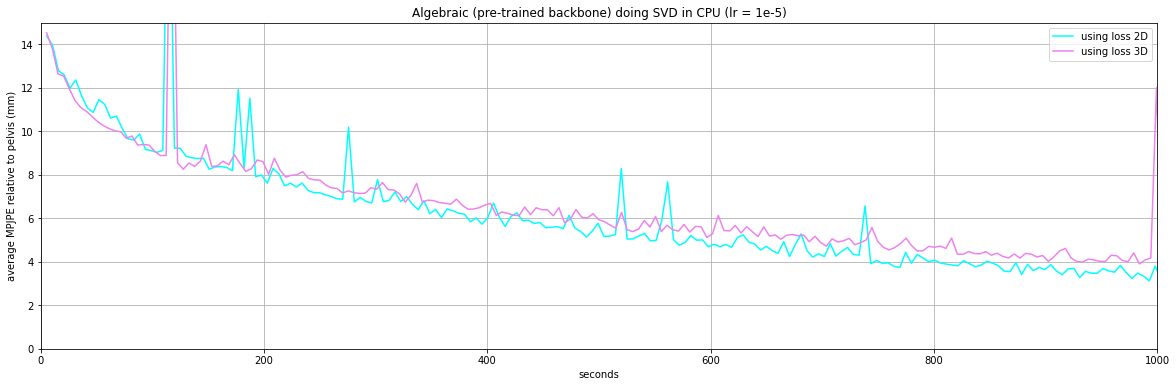

In [104]:
fig, ax = get_figa(1, 1, heigth=6, width=20)

train_metrics, _ = parse_metrics_log(tesi_folder / 'metrics_logs' / 'just_BB_2d.txt')
avg_sec_per_epoch = 3.9 + 1.3  # from `tail -n30 13371604.out`
total_epochs = len(train_metrics)
xrange = avg_sec_per_epoch * np.arange(1, total_epochs + 1)

plot_metric(
    ax,
    train_metrics,
    'using loss 2D',
    xrange=xrange,
    ylim=[3, 17],
    color='cyan',
    legend_loc='upper right'
)

train_metrics, _ = parse_metrics_log(tesi_folder / 'metrics_logs' / 'just_BB_3d.txt')
avg_sec_per_epoch = 3.8 + 1.3  # from `tail -n30 13371657.out`
total_epochs = len(train_metrics)
xrange = avg_sec_per_epoch * np.arange(1, total_epochs + 1)

plot_metric(
    ax,
    train_metrics,
    'using loss 3D',
    xrange=xrange,
    ylim=[3, 17],
    color='violet',
    legend_loc='upper right'
)

ax.set_ylim([0, 15])
ax.set_xlim([0, 1000])
ax.grid(True)

ax.set_title('Algebraic (pre-trained backbone) doing SVD in CPU (lr = 1e-5)')
ax.set_ylabel('average MPJPE relative to pelvis (mm)')
ax.set_xlabel('seconds')

# bench_3D_VS_2D.png